## Birds API

Autonomous recording units are an increasingly popular method of surveying sound-producing animals, such as birds, bats, frogs, and wolves. These recorders are capable of capturing the sounds occurring in a soundscape for months at a time, making them excellent choices for low-cost, large-scale studies. To fully realize their potential, recordings generated by recorders must be scanned by automated techniques.

The analysis of bird songs in recordings is especially challenging due to their enormous diversity. Over the course of a field season, dozens or even hundreds of bird species can be present in a field site, meaning that automated techniques must be able to identify a wide variety of songs. Vocalizations can be highly variable within species, and even within a single individual.

To enable field biologists to study birds at larger scales, we at the [Kitzes Lab](http://www.kitzeslab.org/) are developing a classifier capable of detecting over 500 common species of the United States and Canada. This notebook demonstrates the use of some of our classifiers. Given a short audio file, it splits the file into five-second segments, and outputs the model's top predictions for species present in the files. The classifier is split into models use to detect the following species:

- cardinalis_cardinalis
- haemorhous_mexicanus
- melospiza_melodia
- thryothorus_ludovicianus
- turdus_migratorius
- zenaida_macroura

### Imports and constants

Constants required are:
* `API_URL`: the URL on your local machine of the Docker container
* `WAV_FILE`: the path to a single-channel wav file to analyze, between 5 and 20 seconds long

In [1]:
import io
import json
import requests
import pandas as pd

%autosave 0

API_URL = "http://localhost:8081/v1/birds"
WAV_FILE = "./client/cardinalis-cardinalis.wav"

Autosave disabled


### Functions

In [2]:
def get_audio(inp):
    """
    Read audio file from the filesystem

    Args:
        inp (str): The input audio in WAV format

    Returns: bytes of audio file
    """

    with open(inp, "rb") as audio:
        return audio.read()


def predict(data, endpoint="cardinalis_cardinalis"):
    """
    Predict contents of audio file

    Args:
        data (bytes): audio bytes read from file using get_audio
        endpoint (str): which endpoint to use, one of
            - cardinalis_cardinalis
            - haemorhous_mexicanus
            - melospiza_melodia
            - thryothorus_ludovicianus
            - turdus_migratorius
            - zenaida_macroura
    Returns:
        if request was successful: returns dictionary with key 'predictions'. The key will contain a list of predictions for each 5 second segment in the audio input.
            For each 5 second segment a list of length 2 will be produced. The two values correspond to the weights for negative or positive prediction, respectively.

    Raises:
        exception: if the API raises an unexpected exception
    """

    try:
        r = requests.post(
            f"{API_URL}/detect/{endpoint}",
            data=data,
            headers={"Content-type": "audio/vnd.wav"},
        )

        if r.ok:
            return r.json()
        else:
            return None

    except Exception as e:
        print("Exception running API: {}".format(e))


def get_spect(data):
    """
    Get 5s spectrogram(s) of audio file

    Args:
        data (bytes): audio bytes read from file

    Returns:
        if request was successful: returns dictionary
            with key 'images' equal to a list of grayscale, three-channel
            299 x 299 images, each representing up to 5s of audio,

            This output is a list of lists with the following contents:
                len(images): `num_images` lists
                len(images[0]): 299 lists
                len(images[0][0]): 299 lists
                len(images[0][0][0]): 3 floats from 0-255
                    image is grayscale, so the elements
                    within each innermost array are
                    the same, e.g. [141.0, 141.0, 141.0]

            Each image can be converted to a PIL image using:
                pil_img = Image.fromarray(((np.array(image))).astype(np.uint8))


        if request was not successful: returns None.
            This can happen if the audio was not in the correct
            format (between 5-20 seconds, single-channel)


    """

    try:
        r = requests.post(
            f"{API_URL}/spectrogram",
            data=data,
            headers={"Content-type": "audio/vnd.wav"},
        )

        if r.ok:
            return r.json()
        else:
            return None

    except Exception as e:
        print("Exception running API: {}".format(e))

### Get the bytes of the audio file to send to the API

In [3]:
audio_bytes = get_audio(WAV_FILE)

### Retrieve and run prediction on audio

In [4]:
# Get predictions
result_dict = predict(audio_bytes, endpoint="cardinalis_cardinalis")

if "error" in result_dict.keys():
    print(result_dict["error"])
else:
    for idx, pred in enumerate(result_dict["predictions"]):
        print(f"Segment {idx}:")
        print(f"    No:  {pred[0]:.4f}")
        print(f"    Yes: {pred[1]:.4f}")

Segment 0:
    No:  0.0043
    Yes: 0.9957


### Build spectrogram

This `cardinalis-cardinalis.wav` contains one segment that is predicted to be a cardinal. We can use the `/spectrogram` endpoint to get the spectrogram itself. The length of the `result_dict(["prediction"])` and the `result_dict["images"]` will be the same, i.e. there will only be one image.

In [5]:
import matplotlib.pyplot as plt

In [6]:
result_dict = get_spect(audio_bytes)

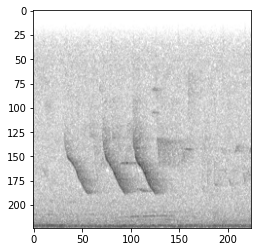

In [7]:
plt.imshow(result_dict["images"][0])

### Opensoundscape

This API is built on top of [opensoundscape](https://github.com/kitzeslab/opensoundscape). Please check out our [documentation](http://opensoundscape.org/en/latest/) to get started 